In [1]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

# Data base import

In [2]:
from utils.split_feelings import split

PATH_TRAIN = Path("../data/samples/sample_1000_train.csv")
PATH_VALID = Path("../data/samples/sample_100_validation.csv")

SPLIT_FEELINGS = True

if SPLIT_FEELINGS:
    POSITIVES_WITH_NEGATIVES = True

    train_pos, train_neutral, train_neg = split(PATH_TRAIN, POSITIVES_WITH_NEGATIVES)
    valid_pos, valid_neutral, valid_neg = split(PATH_VALID, POSITIVES_WITH_NEGATIVES)
    
    train_data = train_pos
    validation_data = valid_pos

else:
    train_data = pd.read_csv(PATH_TRAIN).to_numpy()
    validation_data = pd.read_csv(PATH_VALID).to_numpy()

In [3]:
print(train_data.shape, validation_data.shape)

(666, 4) (60, 4)


In [4]:
from utils.clean_data import clean_data 

train_data = clean_data(train_data)
traivalidation_data = clean_data(validation_data)

In [5]:
print(train_data.shape, validation_data.shape)

(633, 4) (60, 4)


# Pre-processing

In [6]:
# -- Get the original tweets -- #

X_TR_ORIGINAL = train_data[:, 1]
X_VAL_ORIGINAL = validation_data[:, 1]

Y_TR_ORIGINAL = train_data[:, 2]
Y_VAL_ORIGINAL = validation_data[:, 2]

FEELINGS_TR = train_data[:, 3]
FEELINGS_VAL = validation_data[:, 3]

In [7]:
from descriptors.tokenizer.tokenizer import Tokenizer
from descriptors.tweet_string.create_strings import create_strings

WORD_SIZE = 30
SENTENCE_SIZE = 50
FILL_WITH = "$"
FEELING_WEIGHT = 100

# -- Define the tokenizer -- #
TOKENIZER = Tokenizer()

# -- Create sentences -- #
X_TR_STRING = create_strings(X_TR_ORIGINAL, TOKENIZER, SENTENCE_SIZE)
X_VAL_STRING = create_strings(X_VAL_ORIGINAL, TOKENIZER, SENTENCE_SIZE)

Y_TR_STRING = create_strings(Y_TR_ORIGINAL, TOKENIZER, SENTENCE_SIZE)
Y_VAL_STRING = create_strings(Y_VAL_ORIGINAL, TOKENIZER, SENTENCE_SIZE)

print(X_VAL_STRING[0])

['Looking', 'forward', 'to', 'a', 'short', 'work', 'week', 'followed', 'by', 'a', 'mini-vacation', 'in', 'Clemson']


In [8]:
from descriptors.descriptor_ascii.load_data import load_data
from descriptors.descriptor_one_hot.descriptor import descriptor_one_hot
from descriptors.tweet_label.create_labels import create_labels

# ALPHANUM_ONLY = False
# SPLIT_PUNCTUATION = False  # to tell wheter the puncutation "!?.;,/" etc are keeped sticked to a word or not

# training set --------------------------------------------
# X_TR_STRING_FILLED, X_TR_SCALAR = load_data(
#     X_TR_STRING, WORD_SIZE, SENTENCE_SIZE, FILL_WITH, FEELING_WEIGHT, feelings=FEELINGS_TR
# )

X_TR_SCALAR = descriptor_one_hot(
    X_TR_STRING, SENTENCE_SIZE, WORD_SIZE,
    feelings=FEELINGS_TR, feeling_weight=FEELING_WEIGHT, fill_with_ones=True
)

Y_TR = create_labels(X_TR_STRING, Y_TR_STRING, SENTENCE_SIZE)

# validation set ------------------------------------------
# X_VAL_STRING_FILLED, X_VAL_SCALAR = load_data(
#     X_VAL_STRING, WORD_SIZE, SENTENCE_SIZE, FILL_WITH, FEELING_WEIGHT, feelings=FEELINGS_VAL
# )

X_VAL_SCALAR = descriptor_one_hot(
    X_VAL_STRING, SENTENCE_SIZE, WORD_SIZE,
    feelings=FEELINGS_VAL, feeling_weight=FEELING_WEIGHT, fill_with_ones=True
)

Y_VAL = create_labels(X_VAL_STRING, Y_VAL_STRING, SENTENCE_SIZE)

In [9]:
IDX = 0
print("Original data :")
print(X_TR_ORIGINAL[IDX])
# print("\nFilled sentence :")
# print(X_TR_STRING_FILLED[IDX])
print("\nLabel :")
print(Y_TR[IDX])
print("\nDescriptor :")
print(X_TR_SCALAR[IDX])

Original data :
i feel really weird

Label :
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Descriptor :
[   0.    0.    0. ...    0.    0. -100.]


### Standardisation

In [10]:
mu = np.concatenate([X_TR_SCALAR[:, :-1].mean(axis=0), [0]])
sigma = X_TR_SCALAR[:, :-1].std(axis=0)

X_TR_SCALAR = X_TR_SCALAR - mu
X_VAL_SCALAR = X_VAL_SCALAR - mu

for i in range(len(sigma)):
    if sigma[i] != 0:
        X_TR_SCALAR[:, i] /= sigma[i]
        X_VAL_SCALAR[:, i] /= sigma[i]

# Classification

In [11]:
#!pip install xgboost

In [12]:
from sklearn.multioutput import MultiOutputRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [13]:
nb_neighbors = 10
# regressor = KNeighborsRegressor(nb_neighbors, weights="distance", metric="jaccard")
# regressor = KNeighborsRegressor(nb_neighbors, weights="distance")

regressor = MultiOutputRegressor(
    xgb.XGBRegressor(
        objective="reg:squaredlogerror",
        learning_rate=0.3, gamma=0, max_depth=100, reg_lambda=1, tree_method="hist"
    )
)

#regressor = MultiOutputRegressor(
#    SVR(kernel="poly", degree=2)
#)

regressor.fit(X_TR_SCALAR, Y_TR)

/home/alex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:444: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=0,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=100,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='reg:squaredlogerror',
                                            r

In [14]:
predictions = regressor.predict(X_VAL_SCALAR)

In [15]:
from utils.post_processing import preds_to_strings

proba_seil = 0.5

results_val = preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, predictions > proba_seil)

# Accuracy and comparisons

In [16]:
from utils.loss import mean_jaccard

### Average jaccard of predictions

In [17]:
# On train

mean_jaccard(
    train_data[:, 2],
    preds_to_strings(
        X_TR_ORIGINAL, X_TR_STRING, regressor.predict(X_TR_SCALAR)
    )
)

0.32930664298673

In [18]:
# On validation

mean_jaccard(validation_data[:, 2], results_val)

0.15994769119769117

### Average jaccard of full tweets

In [19]:
# On train

mean_jaccard(train_data[:, 2], train_data[:, 1])

0.32930664298673

In [20]:
# On validation

mean_jaccard(validation_data[:, 2], validation_data[:, 1])

0.29367322219080527

### Average jaccard of ground truths
$\neq 100\%$ because of word and sentence cropping

In [21]:
# On train

mean_jaccard(train_data[:, 2], preds_to_strings(X_TR_ORIGINAL, X_TR_STRING, Y_TR))

0.9564317462421726

In [22]:
# On validation

mean_jaccard(validation_data[:, 2], preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, Y_VAL))

0.8702941176470589

# Results display

In [23]:
for i in range(len(predictions)):
    print("Tweet:", i)
    print()
    print("Ground truth", Y_VAL[i])
    print("Predictions", (predictions[i] > proba_seil).astype(float))
    print()
    print("Original Tweet:", X_VAL_ORIGINAL[i])
    print("Cut tweet", X_VAL_STRING[i])
    print()
    print("Meaningfull part:", validation_data[i, 2])
    print("Result:", results_val[i])
    print("\n")

Tweet: 0

Ground truth [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Original Tweet: Looking forward to a short work week followed by a mini-vacation in Clemson
Cut tweet ['Looking', 'forward', 'to', 'a', 'short', 'work', 'week', 'followed', 'by', 'a', 'mini-vacation', 'in', 'Clemson']

Meaningfull part: Looking forward to
Result: a short in Clemson


Tweet: 1

Ground truth [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Original Tweet:  Your missi

Result: f**** work .... ???


Tweet: 14

Ground truth [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Original Tweet: ready for the weekend and sad that I have to be at the office again tomorrow morning
Cut tweet ['ready', 'for', 'the', 'weekend', 'and', 'sad', 'that', 'I', 'have', 'to', 'be', 'at', 'the', 'office', 'again', 'tomorrow', 'morning']

Meaningfull part: sad th
Result: 


Tweet: 15

Ground truth [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 

 0. 0.]

Original Tweet:  good to know PLN`s Earthday doesn`t only happen in my neck of the woods
Cut tweet ['good', 'to', 'know', 'PLN', '`', 's', 'Earthday', 'doesn', '`', 't', 'only', 'happen', 'in', 'my', 'neck', 'of', 'the', 'woods']

Meaningfull part: good to know
Result: doesn


Tweet: 50

Ground truth [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Predictions [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]

Original Tweet: Leaving NOLA today  Counting down the seconds `til I start crying. Love this place so much.
Cut tweet ['Leaving', 'NOLA', 'today', 'Counting', 'down', 'the', 'seconds', '`', 'til', 'I', 'start', 'crying', '.', 'Love', 'this', 'place', 'so', 'much', '.']

Meaningfull part: l I start crying. Love this place so much.
Result: 


Tweet: 51

Ground truth [

In [24]:
# def test_knn(n):
#     regressor = KNeighborsRegressor(n, weights="distance", metric="jaccard")
#     regressor.fit(X_TR_SCALAR, Y_TR)
#     predictions = regressor.predict(X_VAL_SCALAR)
#     results_val = preds_to_strings(X_VAL_ORIGINAL, X_VAL_STRING, predictions)
#     accuracy = mean_jaccard(validation_data[:, 2], results_val)
    
#     return accuracy

In [25]:
# y =[]
# for i in range(2,50, 3):
#     y.append(test_knn(i))
# plt.plot(y)
# plt.show()

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/alex/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


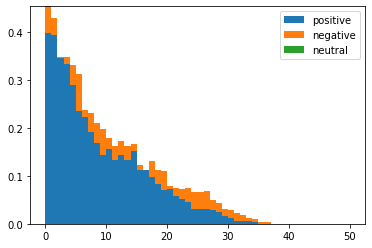

In [26]:
pos_hist = Y_TR[np.where(X_TR_SCALAR[:, -1] > 0)].mean(axis=0)
neg_hist = Y_TR[np.where(X_TR_SCALAR[:, -1] < 0)].mean(axis=0)
neutral_hist = Y_TR[np.where(X_TR_SCALAR[:, -1] == 0)].mean(axis=0)

plt.hist(
    [np.arange(SENTENCE_SIZE), np.arange(SENTENCE_SIZE), np.arange(SENTENCE_SIZE)],
    bins=np.arange(SENTENCE_SIZE + 1),
    weights=[
        pos_hist,
        np.abs(neg_hist - pos_hist),
        np.abs(neutral_hist - np.maximum(pos_hist, neg_hist))
    ],
    stacked=True,
    label=["positive", "negative", "neutral"]
)
plt.legend()
plt.show()